In [1]:
import pandas as pd
import geopandas as gpd

# 读取交通事故数据
accident_data = pd.read_csv(
    'https://raw.githubusercontent.com/YULI61/QM_group_assessment/main/dft-road-casualty-statistics-collision-2023.csv',
    low_memory=False
)


# 读取车流量数据
traffic_data = pd.read_csv('https://github.com/YULI61/QM_group_assessment/raw/refs/heads/main/dft_aadf_region_id_6.csv')

# 读取行政区域边界数据（例如一个 Shapefile）
admin_boundaries = gpd.read_file('https://github.com/YULI61/QM_group_assessment/raw/refs/heads/main/LAD_Dec_2015_FCB_GB_2022_-1836983239597816196/LAD_Dec_2015_FCB_GB.shp')

In [3]:
from shapely.geometry import Point

# 将交通事故数据转换为 GeoDataFrame
accident_data['geometry'] = accident_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
accident_gdf = gpd.GeoDataFrame(accident_data, geometry='geometry', crs="EPSG:4326")

# 将车流量数据转换为 GeoDataFrame
traffic_data['geometry'] = traffic_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
traffic_gdf = gpd.GeoDataFrame(traffic_data, geometry='geometry', crs="EPSG:4326")

# 确保行政区数据的 CRS 与事故和车流量数据一致
admin_boundaries = admin_boundaries.to_crs(epsg=4326)

In [4]:
# 转27700
accident_gdf = accident_gdf.to_crs(epsg=27700)
traffic_gdf = traffic_gdf.to_crs(epsg=27700)
admin_boundaries = admin_boundaries.to_crs(epsg=27700)

print(accident_gdf.crs)

EPSG:27700


In [5]:
# 提取伦敦的数据（假设 'lad15cd' 为行政区编码字段）
london_admin_boundaries = admin_boundaries[admin_boundaries['lad15cd'].str.contains('^E09')]

In [13]:
# 只选择2023年的数据
traffic_2023_gdf = traffic_gdf[traffic_gdf['year'] == 2023]

# 查看提取后的数据u 
print(traffic_2023_gdf.head())

     count_point_id  year  region_id region_name  local_authority_id  \
23             6000  2023          6      London                  57   
47             6001  2023          6      London                  57   
71             6013  2023          6      London                  66   
95             6071  2023          6      London                  93   
119            6075  2023          6      London                  96   

    local_authority_name road_name road_type start_junction_road_name  \
23                Barnet        M1     Major                     A406   
47                Barnet        M1     Major                        2   
71            Hillingdon        M4     Major                        4   
95         Tower Hamlets       A12     Major                      A13   
119            Islington        A1     Major         A503 Camden Road   

                end_junction_road_name  ...   lgvs  hgvs_2_rigid_axle  \
23                             M1 spur  ...  11597     

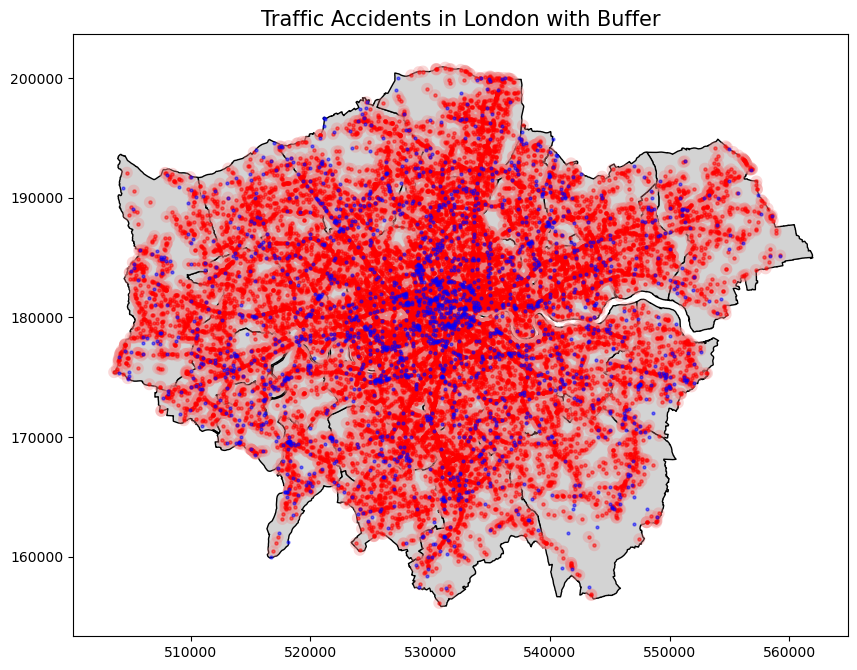

In [30]:
# 使用空间连接将交通事故数据与伦敦行政区进行连接，获取位于伦敦的事故
london_accidents_gdf = gpd.sjoin(accident_gdf, london_admin_boundaries, how="inner", predicate='within')

# 为交通事故数据创建缓冲区，单位为米（假设 500 米）
london_accidents_gdf['buffer'] = london_accidents_gdf.geometry.buffer(500)

# 可视化
fig, ax = plt.subplots(figsize=(10, 10))

# 绘制伦敦行政区边界（灰色）
london_admin_boundaries.plot(ax=ax, color='lightgray', edgecolor='black')

# 绘制交通事故缓冲区（浅红色，透明度设置为0.3）
london_accidents_gdf['buffer'].plot(ax=ax, color='lightcoral', alpha=0.3)

# 绘制伦敦交通事故点（红色）
london_accidents_gdf.plot(ax=ax, color='red', markersize=5, alpha=0.5)

# 绘制车流量检测
traffic_2023_gdf.plot(ax=ax, color='blue', marker='o', label="traffic Points", alpha=0.5, markersize=4)

# 添加标题
ax.set_title('Traffic Accidents in London with Buffer', fontsize=15)

# 显示图形
plt.show()

In [32]:
#即使设置了缓冲区 还是会有交通事故没有对应的检测点
#用行政区车流量来对应

In [42]:
print(london_admin_boundaries.head())

       lad15cd               lad15nm lad15nmw  \
293  E09000001        City of London     None   
294  E09000002  Barking and Dagenham     None   
295  E09000003                Barnet     None   
296  E09000004                Bexley     None   
297  E09000005                 Brent     None   

                                 GlobalID  \
293  e1f49b92-326c-41a3-b695-e7bf86577f2f   
294  ad327cad-7cc8-470d-89a6-6a135f179ce2   
295  e2035a57-3430-44c2-bee4-24d296c62193   
296  b7aa58ca-6753-439d-acd3-04b214e2fecd   
297  ffc966a3-7d4f-4e17-bb64-89353153653e   

                                              geometry  
293  POLYGON ((532140.3 182191.9, 532141.5 182188.7...  
294  MULTIPOLYGON (((548881.8 190803, 548881.2 1907...  
295  POLYGON ((524579.9 198355.2, 524594.3 198321.4...  
296  MULTIPOLYGON (((547801.8 181521.8, 547927 1814...  
297  POLYGON ((520284.7 190241.4, 520319.4 190197.5...  


In [46]:
# 使用空间连接将每个事故点匹配到所属的行政区
# 在行政区中使用 'lad15nm' 列作为区域名称
london_accidents_gdf = gpd.sjoin(
    london_accidents_gdf, 
    london_admin_boundaries[['geometry', 'lad15nm']],  # 只保留必要的列
    how="left", 
    predicate='within',
    lsuffix='accident',  # 为左表的列添加后缀
    rsuffix='boundary'   # 为右表的列添加后缀
)

# 将 'lad15nm' 重命名为 'local_authority_name'
london_accidents_gdf = london_accidents_gdf.rename(columns={'lad15nm': 'local_authority_name'})

# 删除空间连接过程中生成的多余列
london_accidents_gdf = london_accidents_gdf.drop(columns=['index_boundary'])

# 查看结果，确认每个事故点是否得到了正确的行政区
print(london_accidents_gdf.head())

  accident_index  accident_year accident_reference  location_easting_osgr  \
0  2023010419171           2023          010419171               525060.0   
1  2023010419183           2023          010419183               535463.0   
2  2023010419189           2023          010419189               508702.0   
3  2023010419191           2023          010419191               520341.0   
4  2023010419192           2023          010419192               527255.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                170416.0  -0.202878  51.418974             1   
1                198745.0  -0.042464  51.671155             1   
2                177696.0  -0.435789  51.487777             1   
3                190175.0  -0.263972  51.597575             1   
4                176963.0  -0.168976  51.477324             1   

   accident_severity  number_of_vehicles  ...  lad15nm_left lad15nmw_left  \
0                  3                   1  ...        Merton          

In [51]:
print(traffic_2023_gdf.columns)

Index(['count_point_id', 'year', 'region_id', 'region_name',
       'local_authority_id', 'local_authority_name', 'road_name', 'road_type',
       'start_junction_road_name', 'end_junction_road_name', 'easting',
       'northing', 'latitude', 'longitude', 'link_length_km',
       'link_length_miles', 'estimation_method', 'estimation_method_detailed',
       'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
       'buses_and_coaches', 'lgvs', 'hgvs_2_rigid_axle', 'hgvs_3_rigid_axle',
       'hgvs_4_or_more_rigid_axle', 'hgvs_3_or_4_articulated_axle',
       'hgvs_5_articulated_axle', 'hgvs_6_articulated_axle', 'all_hgvs',
       'all_motor_vehicles', 'geometry'],
      dtype='object')


In [52]:
# 提取 traffic_2023_gdf 中的 'local_authority_name' 和 'all_motor_vehicles'
traffic_data = traffic_2023_gdf[['local_authority_name', 'all_motor_vehicles']]

# 按照 'local_authority_name' 分组，并计算每个行政区的总车流量
traffic_summary = traffic_data.groupby('local_authority_name', as_index=False).sum()

# 重命名列名为更具语义的名称
traffic_summary = traffic_summary.rename(columns={
    'local_authority_name': 'Administrative Area',
    'all_motor_vehicles': 'Total Traffic Volume'
})

# 查看结果
print(traffic_summary.head())

    Administrative Area  Total Traffic Volume
0  Barking and Dagenham                778903
1                Barnet               2884424
2                Bexley               1444272
3                 Brent               1399297
4               Bromley                944088


In [53]:
# 确保列名一致，便于合并
traffic_summary = traffic_summary.rename(columns={'Administrative Area': 'local_authority_name'})

# 将车流量数据合并到 london_accidents_gdf
london_accidents_gdf = london_accidents_gdf.merge(
    traffic_summary,
    on='local_authority_name',  # 按照行政区名称匹配
    how='left'                 # 使用左连接，保留所有事故点，即使有些区没有车流量数据
)

# 查看结果
print(london_accidents_gdf.head())

  accident_index  accident_year accident_reference  location_easting_osgr  \
0  2023010419171           2023          010419171               525060.0   
1  2023010419183           2023          010419183               535463.0   
2  2023010419189           2023          010419189               508702.0   
3  2023010419191           2023          010419191               520341.0   
4  2023010419192           2023          010419192               527255.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                170416.0  -0.202878  51.418974             1   
1                198745.0  -0.042464  51.671155             1   
2                177696.0  -0.435789  51.487777             1   
3                190175.0  -0.263972  51.597575             1   
4                176963.0  -0.168976  51.477324             1   

   accident_severity  number_of_vehicles  ...  lad15nmw_left  \
0                  3                   1  ...           None   
1                 